# Assignment 2: MNIST

## 3. Read the data

In [1]:
import struct

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
class MNIST:
    def __init__(self):
        # read images and labels from binaries
        self.train_images = self.read_data("train-images-idx3-ubyte")
        self.train_labels = self.read_data("train-labels-idx1-ubyte")
        self.test_images = self.read_data("t10k-images-idx3-ubyte")
        self.test_labels = self.read_data("t10k-labels-idx1-ubyte")

        # reshape data and labels to the correct format
        self.train_data = self.train_images.reshape(60000, 784)
        self.train_labels = np.identity(10)[self.train_labels]
        self.test_data = self.test_images.reshape(10000, 784)
        self.test_labels = np.identity(10)[self.test_labels]

    def read_data(self, filename):
        with open(filename, 'rb') as file:
            _, num = struct.unpack('>ii', file.read(8))

            if "images" in filename:
                height, width = struct.unpack('>II', file.read(8))
                images = np.fromfile(file, dtype='uint8')
                return np.reshape(images, (num, height, width))
            elif "labels" in filename:
                return np.fromfile(file, dtype='uint8')
            else:
                raise ValueError("Not a MNIST file: " + filename)

    def get_batch(self, data, labels, batch_size):
        for i in range(len(data) // batch_size):
            first = i * batch_size
            last = first + batch_size
            yield data[first:last], labels[first:last]

## 4. Investigate the data

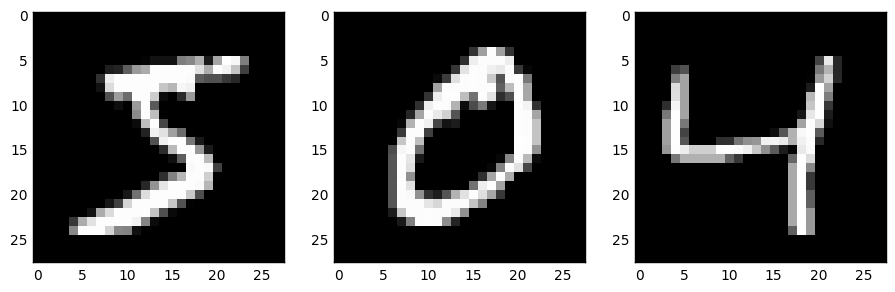

In [3]:
mnist = MNIST()

# plot some handwritten digits
fig = plt.figure(figsize=(11, 4))
fig.add_subplot(131)
plt.imshow(mnist.train_images[0], cmap='gray', interpolation='nearest')
fig.add_subplot(132)
plt.imshow(mnist.train_images[1], cmap='gray', interpolation='nearest')
fig.add_subplot(133)
plt.imshow(mnist.train_images[2], cmap='gray', interpolation='nearest')
plt.show()

## 5. Implement the DFG

In [4]:
# training hyper-parameters
epochs = 3
learning_rate = 1e-5
num_train_samples = 54000
batch_size = 100

In [5]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
W = tf.Variable(tf.random_normal([784, 10], stddev=2e-7))
b = tf.Variable(tf.zeros([10]))

y_hat = tf.matmul(x, W) + b
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

## 6. Train the network

In [6]:
np.random.seed(1)

entropy_history = np.zeros((num_train_samples // batch_size * epochs, 2))
accuracy_history = np.zeros((num_train_samples // batch_size * epochs, 2))
weight_history = np.zeros((num_train_samples // batch_size * epochs, 10, 784))
train_step = 0

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    for _ in range(epochs):
        # shuffle samples
        num_samples = mnist.train_labels.shape[0]
        indices = np.random.choice(num_samples, num_samples, replace=False)
        data = mnist.train_data[indices]
        labels = mnist.train_labels[indices]
        
        for batch in mnist.get_batch(data[:num_train_samples], labels[:num_train_samples], batch_size):
            session.run(train, feed_dict={x: batch[0], y: batch[1]})

            # save learning history
            entropy_history[train_step][0] = session.run(loss, feed_dict={x: batch[0], y: batch[1]})
            accuracy_history[train_step][0] = session.run(accuracy, feed_dict={x: batch[0], y: batch[1]})

            # validate model
            if train_step % 100 == 0:
                entropy_history[train_step][1] = session.run(loss, feed_dict={x: data[num_train_samples:], 
                                                                              y: labels[num_train_samples:]})
                accuracy_history[train_step][1] = session.run(accuracy, feed_dict={x: data[num_train_samples:], 
                                                                                   y: labels[num_train_samples:]})
                weight_history[train_step] = np.transpose(session.run(W))
            else:
                entropy_history[train_step][1] = entropy_history[train_step-1][1]
                accuracy_history[train_step][1] = accuracy_history[train_step-1][1]
                weight_history[train_step] = weight_history[train_step-1]

            train_step += 1
            
    result = session.run(accuracy, feed_dict={x: mnist.test_data, y: mnist.test_labels})
    print("Test accurancy: ", result * 100, "%")

Test accurancy:  91.0099983215 %


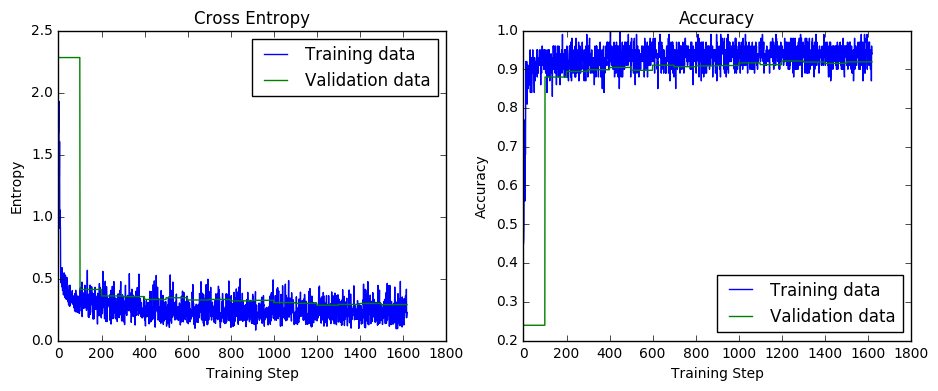

In [7]:
fig = plt.figure(figsize=(11, 4))

# plot cross entropy
ax = fig.add_subplot(121)
ax.plot(range(train_step), entropy_history)
ax.set_title("Cross Entropy")
ax.set_xlabel("Training Step")
ax.set_ylabel("Entropy")
ax.legend(("Training data", "Validation data"))

# plot accuracy
ax = fig.add_subplot(122)
ax.plot(range(train_step), accuracy_history)
ax.set_title("Accuracy")
ax.set_xlabel("Training Step")
ax.set_ylabel("Accuracy")
ax.legend(("Training data", "Validation data"), loc=4)

plt.show()

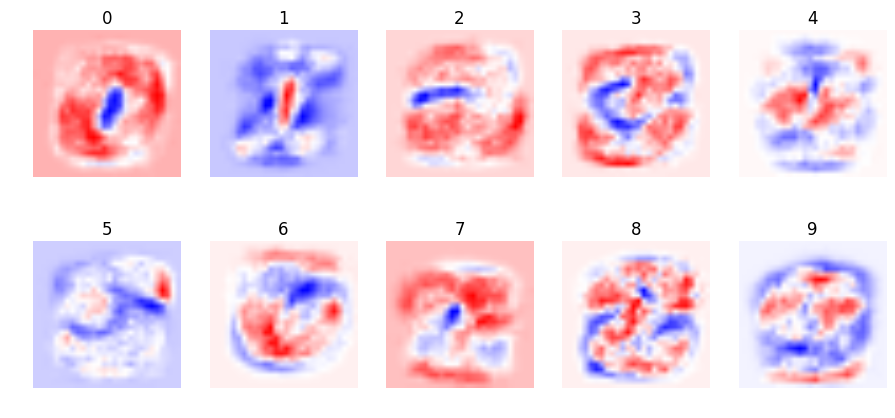

In [8]:
weight_history = np.reshape(weight_history, (weight_history.shape[:2] + (28, 28)))

# plot weights
fig = plt.figure(figsize=(11, 5))

ax = fig.add_subplot(2, 5, 1)
ax.set_title("0")
ax.set_axis_off()
plt.imshow(weight_history[-1][0], cmap='bwr')

ax = fig.add_subplot(2, 5, 2)
ax.set_title("1")
ax.set_axis_off()
plt.imshow(weight_history[-1][1], cmap='bwr')

ax = fig.add_subplot(2, 5, 3)
ax.set_title("2")
ax.set_axis_off()
plt.imshow(weight_history[-1][2], cmap='bwr')

ax = fig.add_subplot(2, 5, 4)
ax.set_title("3")
ax.set_axis_off()
plt.imshow(weight_history[-1][3], cmap='bwr')

ax = fig.add_subplot(2, 5, 5)
ax.set_title("4")
ax.set_axis_off()
plt.imshow(weight_history[-1][4], cmap='bwr')

ax = fig.add_subplot(2, 5, 6)
ax.set_title("5")
ax.set_axis_off()
plt.imshow(weight_history[-1][5], cmap='bwr')

ax = fig.add_subplot(2, 5, 7)
ax.set_title("6")
ax.set_axis_off()
plt.imshow(weight_history[-1][6], cmap='bwr')

ax = fig.add_subplot(2, 5, 8)
ax.set_title("7")
ax.set_axis_off()
plt.imshow(weight_history[-1][7], cmap='bwr')

ax = fig.add_subplot(2, 5, 9)
ax.set_title("8")
ax.set_axis_off()
plt.imshow(weight_history[-1][8], cmap='bwr')

ax = fig.add_subplot(2, 5, 10)
ax.set_title("9")
ax.set_axis_off()
plt.imshow(weight_history[-1][9], cmap='bwr')

plt.show()